In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import cv2
import numpy as np
import os
import random
import wandb
import matplotlib.pyplot as plt
from tqdm import tqdm
import torchvision.models as models
from skimage.morphology import disk
from skimage.filters import median

In [2]:
# NSA Patch Extraction function
def nsa_patch_extraction(ima_dest, ima_src=None, same=False, mode=cv2.NORMAL_CLONE):
    """
    Extract a patch from the source image and blend it into the destination image using NSA technique.
    """
    width_bounds_pct = ((0.05, 0.2), (0.05, 0.2))  # Default width bounds
    resize = True
    ima_src = ima_dest.copy() if same or (ima_src is None) else ima_src
    mask = np.zeros_like(ima_dest[..., 0:1])  # Single channel mask for the patch

    # Extract and blend patches
    patchex = ima_dest.copy()
    dims = np.array(ima_dest.shape)
    min_width_dim1 = (width_bounds_pct[0][0] * dims[0]).round().astype(int)
    max_width_dim1 = (width_bounds_pct[0][1] * dims[0]).round().astype(int)
    min_width_dim2 = (width_bounds_pct[1][0] * dims[1]).round().astype(int)
    max_width_dim2 = (width_bounds_pct[1][1] * dims[1]).round().astype(int)
    patch_width_dim1 = np.random.randint(min_width_dim1, max_width_dim1)
    patch_width_dim2 = np.random.randint(min_width_dim2, max_width_dim2)
    center_dim1 = np.random.randint(patch_width_dim1, dims[0] - patch_width_dim1)
    center_dim2 = np.random.randint(patch_width_dim2, dims[1] - patch_width_dim2)

    # Define the bounding box of the patch
    coor_min_dim1 = np.clip(center_dim1 - patch_width_dim1, 0, dims[0])
    coor_min_dim2 = np.clip(center_dim2 - patch_width_dim2, 0, dims[1])
    coor_max_dim1 = np.clip(center_dim1 + patch_width_dim1, 0, dims[0])
    coor_max_dim2 = np.clip(center_dim2 + patch_width_dim2, 0, dims[1])

    # Extract patch from source
    patch = ima_src[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]
    height, width, _ = patch.shape

    # If resizing is enabled, rescale the patch
    if resize:
        lb, ub = (0.7, 1.3)
        scale = np.clip(np.random.normal(1, 0.5), lb, ub)
        new_height = np.clip(int(scale * height), min_width_dim1, max_width_dim1)
        new_width = np.clip(int(new_height / height * width), min_width_dim2, max_width_dim2)
        patch = cv2.resize(patch, (new_width, new_height))
        height, width, _ = patch.shape

    # Sample destination location and paste patch
    found_center = False
    while not found_center:
        center_dim1 = np.random.randint(height // 2 + 1, ima_dest.shape[0] - height // 2 - 1)
        center_dim2 = np.random.randint(width // 2 + 1, ima_dest.shape[1] - width // 2 - 1)
        coor_min_dim1, coor_max_dim1 = center_dim1 - height // 2, center_dim1 + (height + 1) // 2
        coor_min_dim2, coor_max_dim2 = center_dim2 - width // 2, center_dim2 + (width + 1) // 2
        found_center = True

    # Perform the blending using Poisson editing (seamlessClone)
    patch_mask = np.ones((height, width, 1), dtype=np.uint8) * 255
    try:
        center = (coor_min_dim2 + (coor_max_dim2 - coor_min_dim2) // 2, coor_min_dim1 + (coor_max_dim1 - coor_min_dim1) // 2)
        patchex = cv2.seamlessClone(patch, ima_dest, patch_mask, center, mode)
    except cv2.error as e:
        print(f"WARNING: Poisson blending failed: {e}. Using original destination.")
        patchex = ima_dest.copy()

    # Store bounding box coordinates for visualization
    bbox = (coor_min_dim2, coor_min_dim1, coor_max_dim2, coor_max_dim1)

    return patchex, bbox


In [3]:
# FPI Patch Extraction function
def fpi_patch_extraction(ima_dest, ima_src=None, same=False, mode=cv2.NORMAL_CLONE):
    """
    Extract a patch from the source image and blend it into the destination image using FPI technique.
    """
    width_bounds_pct = ((0.1, 0.25), (0.1, 0.25))  # FPI width bounds
    resize = True
    ima_src = ima_dest.copy() if same or (ima_src is None) else ima_src
    mask = np.zeros_like(ima_dest[..., 0:1])  # Single channel mask for the patch

    # Extract and blend patches
    patchex = ima_dest.copy()
    dims = np.array(ima_dest.shape)
    min_width_dim1 = (width_bounds_pct[0][0] * dims[0]).round().astype(int)
    max_width_dim1 = (width_bounds_pct[0][1] * dims[0]).round().astype(int)
    min_width_dim2 = (width_bounds_pct[1][0] * dims[1]).round().astype(int)
    max_width_dim2 = (width_bounds_pct[1][1] * dims[1]).round().astype(int)
    patch_width_dim1 = np.random.randint(min_width_dim1, max_width_dim1)
    patch_width_dim2 = np.random.randint(min_width_dim2, max_width_dim2)
    center_dim1 = np.random.randint(patch_width_dim1, dims[0] - patch_width_dim1)
    center_dim2 = np.random.randint(patch_width_dim2, dims[1] - patch_width_dim2)

    # Define the bounding box of the patch
    coor_min_dim1 = np.clip(center_dim1 - patch_width_dim1, 0, dims[0])
    coor_min_dim2 = np.clip(center_dim2 - patch_width_dim2, 0, dims[1])
    coor_max_dim1 = np.clip(center_dim1 + patch_width_dim1, 0, dims[0])
    coor_max_dim2 = np.clip(center_dim2 + patch_width_dim2, 0, dims[1])

    # Extract patch from source
    patch = ima_src[coor_min_dim1:coor_max_dim1, coor_min_dim2:coor_max_dim2]
    height, width, _ = patch.shape

    # If resizing is enabled, rescale the patch
    if resize:
        lb, ub = (0.8, 1.5)
        scale = np.clip(np.random.normal(1, 0.5), lb, ub)
        new_height = np.clip(int(scale * height), min_width_dim1, max_width_dim1)
        new_width = np.clip(int(new_height / height * width), min_width_dim2, max_width_dim2)
        patch = cv2.resize(patch, (new_width, new_height))
        height, width, _ = patch.shape

    # Sample destination location and paste patch
    found_center = False
    while not found_center:
        center_dim1 = np.random.randint(height // 2 + 1, ima_dest.shape[0] - height // 2 - 1)
        center_dim2 = np.random.randint(width // 2 + 1, ima_dest.shape[1] - width // 2 - 1)
        coor_min_dim1, coor_max_dim1 = center_dim1 - height // 2, center_dim1 + (height + 1) // 2
        coor_min_dim2, coor_max_dim2 = center_dim2 - width // 2, center_dim2 + (width + 1) // 2
        found_center = True

    # Perform the blending using Poisson editing (seamlessClone)
    patch_mask = np.ones((height, width, 1), dtype=np.uint8) * 255
    try:
        center = (coor_min_dim2 + (coor_max_dim2 - coor_min_dim2) // 2, coor_min_dim1 + (coor_max_dim1 - coor_min_dim1) // 2)
        patchex = cv2.seamlessClone(patch, ima_dest, patch_mask, center, mode)
    except cv2.error as e:
        print(f"WARNING: Poisson blending failed: {e}. Using original destination.")
        patchex = ima_dest.copy()

    # Store bounding box coordinates for visualization
    bbox = (coor_min_dim2, coor_min_dim1, coor_max_dim2, coor_max_dim1)

    return patchex, bbox

In [4]:
# CutPaste Patch Extraction function
def cutpaste_patch_extraction(ima_dest, ima_src=None, same=False):
    """
    Extract a patch from the source image and paste it into the destination image using CutPaste technique.
    """
    ima_src = ima_dest.copy() if same or (ima_src is None) else ima_src

    # Sample patch size and location
    dims = np.array(ima_dest.shape)
    area_ratio = np.random.uniform(0.02, 0.15)
    aspect_ratio = np.random.choice([np.random.uniform(0.3, 1), np.random.uniform(1, 3.3)])

    patch_height = int(np.sqrt(area_ratio * aspect_ratio * dims[0] * dims[1]))
    patch_width = int(np.sqrt(area_ratio / aspect_ratio * dims[0] * dims[1]))

    # Ensure patch fits within image dimensions
    patch_height = min(patch_height, dims[0])
    patch_width = min(patch_width, dims[1])

    # Randomly sample patch position in source and destination images
    src_top = np.random.randint(0, dims[0] - patch_height)
    src_left = np.random.randint(0, dims[1] - patch_width)
    dest_top = np.random.randint(0, dims[0] - patch_height)
    dest_left = np.random.randint(0, dims[1] - patch_width)

    # Extract and paste patch
    patch = ima_src[src_top:src_top + patch_height, src_left:src_left + patch_width]
    patchex = ima_dest.copy()
    patchex[dest_top:dest_top + patch_height, dest_left:dest_left + patch_width] = patch

    # Store bounding box coordinates for visualization
    bbox = (dest_left, dest_top, dest_left + patch_width, dest_top + patch_height)

    return patchex, bbox

In [5]:
# Custom Dataset class with Patch Extraction for synthetic anomalies
class MVTecNSADataset(Dataset):
    def __init__(self, root_dir, split="train", transform=None, mode="nsa"):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.mode = mode
        self.image_paths = []
        self.bboxes = []
        for root, _, files in os.walk(os.path.join(root_dir, split)):
            for fname in files:
                if fname.endswith(('.png', '.jpg', '.jpeg')):
                    self.image_paths.append(os.path.join(root, fname))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        if idx >= len(self.image_paths):
            raise IndexError("Index out of range for dataset.")
        
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)

        # Retry mechanism to avoid returning None
        retry_count = 0
        while image is None and retry_count < 5:
            idx = random.randint(0, len(self.image_paths) - 1)
            img_path = self.image_paths[idx]
            image = cv2.imread(img_path)
            retry_count += 1

        if image is None:
            raise ValueError(f"Image at path {img_path} could not be loaded.")

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (256, 256))
        bbox = None
        
        # Apply Patch Extraction for synthetic anomalies
        if self.split == "train":
            source_idx = random.randint(0, len(self.image_paths) - 1)
            source_img_path = self.image_paths[source_idx]
            source_image = cv2.imread(source_img_path)

            # Retry mechanism for source image
            retry_count = 0
            while source_image is None and retry_count < 5:
                source_idx = random.randint(0, len(self.image_paths) - 1)
                source_img_path = self.image_paths[source_idx]
                source_image = cv2.imread(source_img_path)
                retry_count += 1

            if source_image is None:
                raise ValueError(f"Source image at path {source_img_path} could not be loaded.")

            source_image = cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB)
            source_image = cv2.resize(source_image, (256, 256))

            # Apply patch extraction based on mode
            if self.mode == "nsa":
                image, bbox = nsa_patch_extraction(image, ima_src=source_image, same=False)
            elif self.mode == "fpi":
                image, bbox = fpi_patch_extraction(image, ima_src=source_image, same=False)
            elif self.mode == "cutpaste":
                image, bbox = cutpaste_patch_extraction(image, ima_src=source_image, same=False)
        
        if self.transform:
            image = self.transform(image)
        elif isinstance(image, np.ndarray):
            image = torch.from_numpy(image).permute(2, 0, 1).float() / 255.0
        else:
            raise TypeError("Expected image to be a numpy ndarray, but got {}".format(type(image)))
        
        # Ensure that the bounding box is not None and is always returned
        if bbox is None:
            bbox = (0, 0, 0, 0)

        return image, bbox

In [6]:
# Visualize dataset samples with bounding box for localization
# Expected output: Displays images from the dataset, highlighting the synthetic anomaly using a bounding box
def visualize_dataset_samples_with_localization(dataset, num_samples=8):
    fig, axes = plt.subplots(1, num_samples, figsize=(20, 5))
    for i in range(num_samples):
        try:
            # Load the image with synthetic anomaly
            image, bbox = dataset[i]
            image_np = image.permute(1, 2, 0).numpy()

            # Plot the image with synthetic anomaly and bounding box
            axes[i].imshow(image_np)
            axes[i].axis('off')
            axes[i].set_title("Image with Synthetic Anomaly")

            # Draw bounding box if available
            if bbox != (0, 0, 0, 0):
                x_min, y_min, x_max, y_max = bbox
                rect = plt.Rectangle((x_min, y_min), x_max - x_min, y_max - y_min,
                                     linewidth=2, edgecolor='r', facecolor='none')
                axes[i].add_patch(rect)
        except (ValueError, IndexError) as e:
            print(e)

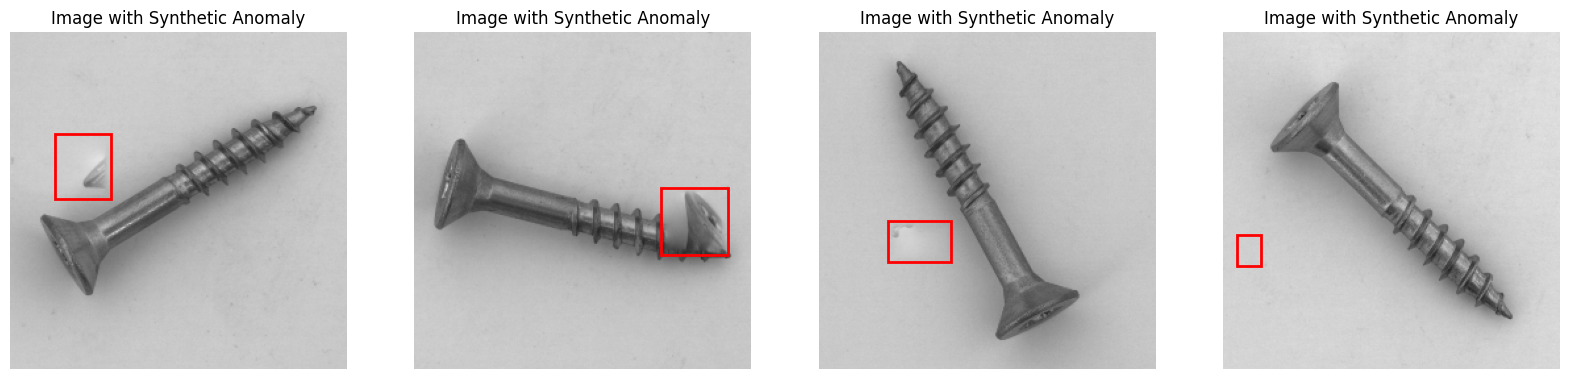

In [7]:
# Analyze and visualize the training dataset
train_dataset = MVTecNSADataset("./datasets/mvtec/screw", split="train", mode="nsa")
visualize_dataset_samples_with_localization(train_dataset, num_samples=4)

In [8]:
# Model class: ResNet Encoder-Decoder with TransposeBasicBlock
class TransposeBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(TransposeBasicBlock, self).__init__()
        self.conv1 = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.upsample = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=1, stride=2, output_padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
    
    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)

        # Perform upsampling path
        upsampled = self.upsample(x)

        return self.relu(out + upsampled)

class ResNetEncDec(nn.Module):
    def __init__(self):
        super(ResNetEncDec, self).__init__()

        # Encoder: Using ResNet layers up to layer4
        resnet = models.resnet18(pretrained=True)
        
        # Encoder layers
        self.conv1 = resnet.conv1
        self.bn1 = resnet.bn1
        self.relu = resnet.relu
        self.maxpool = resnet.maxpool
        self.layer1 = resnet.layer1
        self.layer2 = resnet.layer2
        self.layer3 = resnet.layer3
        self.layer4 = resnet.layer4

        # NIN layer (512 -> 256 -> 128)
        self.nin = nn.Sequential(
            nn.Conv2d(512, 256, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 128, kernel_size=1, stride=1, bias=False),
            nn.ReLU(inplace=True)
        )

        # Decoder (TransposeBasicBlock layers)
        self.uplayer1 = TransposeBasicBlock(128, 64)
        self.uplayer2 = TransposeBasicBlock(64, 32)
        self.uplayer3 = TransposeBasicBlock(32, 16)

        # Upsampling
        self.upsample = nn.Upsample(scale_factor=2.0, mode='bilinear')

        # Final conv layer
        self.convtranspose1 = nn.ConvTranspose2d(16, 1, kernel_size=7, stride=2, padding=3, output_padding=1, bias=False)

        # Final activation (Identity in this case)
        self.final_activation = nn.Identity()

    def forward(self, x):
        # Encoder
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
        
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        # NIN Layer
        x = self.nin(x)

        # Decoder layers
        x = self.uplayer1(x)
        x = self.uplayer2(x)
        x = self.uplayer3(x)

        # Upsample
        x = self.upsample(x)

        # Final convolution
        x = self.convtranspose1(x)

        # Final activation (here it's Identity)
        x = self.final_activation(x)

        return x

In [9]:
# Initialize model, optimizer, and loss function
model = ResNetEncDec().to('cuda')
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
# Training epoch function
def train_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for images, _ in tqdm(loader, desc="Training", leave=False):
        images = images.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

In [11]:
# Validation epoch function
def validate_epoch(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for images, _ in tqdm(loader, desc="Validation", leave=False):
            images = images.to(device)
            outputs = model(images)
            loss = criterion(outputs, images)
            total_loss += loss.item()
    return total_loss / len(loader)

In [12]:
# Training Function with Model Checkpointing
def train_model(model, train_loader, val_loader, optimizer, criterion, device, num_epochs=50):
    wandb.init(project="nsa_mvtec_training", config={"epochs": num_epochs, "batch_size": train_loader.batch_size, "learning_rate": 1e-4})
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        print(f"Epoch [{epoch+1}/{num_epochs}]")
        # Training
        train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
        wandb.log({"train_loss": train_loss, "epoch": epoch+1})

        # Validation
        val_loss = validate_epoch(model, val_loader, criterion, device)
        wandb.log({"val_loss": val_loss, "epoch": epoch+1})

        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), "best_model.pth")
            print(f"Best model saved with validation loss: {best_val_loss:.4f}")


In [58]:
# Initialize DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = MVTecNSADataset("./datasets/mvtec/screw/", split="test", mode="nsa")
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [14]:
# Train the model
train_model(model, train_loader, val_loader, optimizer, criterion, device='cuda', num_epochs=50)

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: sameerhashmi1995 (AVS7_IPCV_742). Use `wandb login --relogin` to force relogin


Epoch [1/50]


Training:   0%|          | 0/10 [00:00<?, ?it/s]/home/sameerhashmi36/miniconda3/envs/test/lib/python3.10/site-packages/torch/nn/modules/loss.py:535: UserWarning: Using a target size (torch.Size([32, 3, 256, 256])) that is different to the input size (torch.Size([32, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Best model saved with validation loss: 0.5762
Epoch [2/50]


Epoch [3/50]


Epoch [4/50]


Best model saved with validation loss: 0.5495
Epoch [5/50]


Best model saved with validation loss: 0.5451
Epoch [6/50]


Best model saved with validation loss: 0.5076
Epoch [7/50]


Best model saved with validation loss: 0.4398
Epoch [8/50]


Best model saved with validation loss: 0.3820
Epoch [9/50]


Best model saved with validation loss: 0.3286
Epoch [10/50]


Best model saved with validation loss: 0.2819
Epoch [11/50]


Best model saved with validation loss: 0.2285
Epoch [12/50]


Best model saved with validation loss: 0.1824
Epoch [13/50]


Best model saved with validation loss: 0.1490
Epoch [14/50]


Best model saved with validation loss: 0.1210
Epoch [15/50]


Best model saved with validation loss: 0.1082
Epoch [16/50]


Best model saved with validation loss: 0.0932
Epoch [17/50]


Best model saved with validation loss: 0.0740
Epoch [18/50]


Best model saved with validation loss: 0.0617
Epoch [19/50]


Best model saved with validation loss: 0.0516
Epoch [20/50]


Best model saved with validation loss: 0.0450
Epoch [21/50]


Best model saved with validation loss: 0.0394
Epoch [22/50]


Best model saved with validation loss: 0.0361
Epoch [23/50]


Best model saved with validation loss: 0.0335
Epoch [24/50]


Best model saved with validation loss: 0.0309
Epoch [25/50]


Best model saved with validation loss: 0.0290
Epoch [26/50]


Best model saved with validation loss: 0.0274
Epoch [27/50]


Best model saved with validation loss: 0.0256
Epoch [28/50]


Best model saved with validation loss: 0.0242
Epoch [29/50]


Best model saved with validation loss: 0.0231
Epoch [30/50]


Best model saved with validation loss: 0.0222
Epoch [31/50]


Best model saved with validation loss: 0.0217
Epoch [32/50]


Best model saved with validation loss: 0.0207
Epoch [33/50]


Best model saved with validation loss: 0.0197
Epoch [34/50]


Best model saved with validation loss: 0.0190
Epoch [35/50]


Best model saved with validation loss: 0.0184
Epoch [36/50]


Best model saved with validation loss: 0.0179
Epoch [37/50]


Best model saved with validation loss: 0.0174
Epoch [38/50]


Best model saved with validation loss: 0.0167
Epoch [39/50]


Best model saved with validation loss: 0.0162
Epoch [40/50]


Best model saved with validation loss: 0.0158
Epoch [41/50]


Best model saved with validation loss: 0.0156
Epoch [42/50]


Best model saved with validation loss: 0.0152
Epoch [43/50]


Best model saved with validation loss: 0.0147
Epoch [44/50]


Best model saved with validation loss: 0.0143
Epoch [45/50]


Best model saved with validation loss: 0.0139
Epoch [46/50]


Best model saved with validation loss: 0.0135
Epoch [47/50]


Best model saved with validation loss: 0.0132
Epoch [48/50]


Best model saved with validation loss: 0.0129
Epoch [49/50]


Best model saved with validation loss: 0.0126
Epoch [50/50]


Best model saved with validation loss: 0.0123


In [15]:
# Finish wandb run
wandb.finish()

epoch,▁▁▂▂▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇█
train_loss,█▅▅▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█████▆▆▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,50
train_loss,0.01267
val_loss,0.01229
